In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx

In [25]:
df = pd.read_csv("market_basket.csv")

df.head() #Display dataset

,order,Apple,Bread,Butter,Cheese,Corn,Dill,Eggs,Ice cream,Kidney_Beans,Milk,Nutmeg,Onion,Sugar,Unicorn,Yogurt,Chocolate
0,0,False,True,False,False,True,True,False,True,False,False,False,False,True,False,True,True
1,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,2,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,True
3,3,False,False,True,True,False,True,False,False,False,True,True,True,False,False,False,False
4,4,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [26]:
min_support = 0.2 #minimum support
min_confidence = 0.5 #minimum confidence
k = 2 #number of items in relationship

df = df.drop('order', axis=1)
df.head()

,Apple,Bread,Butter,Cheese,Corn,Dill,Eggs,Ice cream,Kidney_Beans,Milk,Nutmeg,Onion,Sugar,Unicorn,Yogurt,Chocolate
0,False,True,False,False,True,True,False,True,False,False,False,False,True,False,True,True
1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,True
3,False,False,True,True,False,True,False,False,False,True,True,True,False,False,False,False
4,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


<BarContainer object of 16 artists>

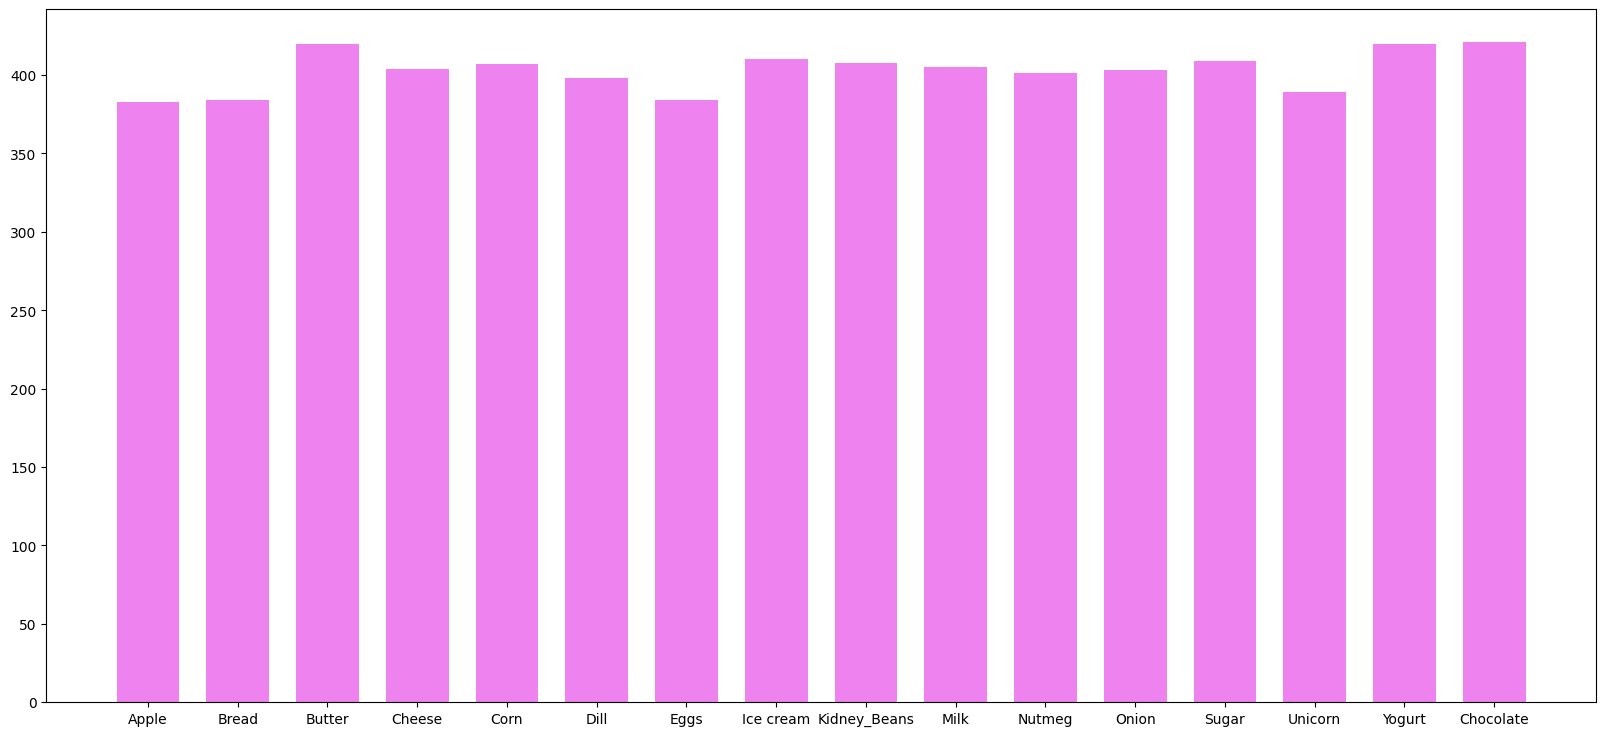

In [27]:
true_counts = df.sum(numeric_only=True)

#Display a bar graph that shows the amount items are in each food 
fig = plt.subplots(figsize =(20, 9))
plt.bar(df.columns, true_counts, 0.7, color="violet")

In [28]:
# function for getting the support of each item
def get_support(itemset, df):
    count = 0
    for _, row in df.iterrows():
        if all(row[item] for item in itemset):
            count += 1
    return count / len(df)

In [29]:
items = df.columns.tolist()
frequent_itemsets = []
support_data = {} # store support for quick lookup
current_itemsets = []

In [30]:
# iterates through the list of items and assigns the support for each one
for item in items:
    support = get_support([item], df)
    if support >= min_support:
        itemset = frozenset([item])
        current_itemsets.append(itemset)
        support_data[itemset] = support
        frequent_itemsets.append(itemset)

In [ ]:
# iterates through current_itemsets to obtain sets of items for forming association rules
while current_itemsets:
    candidate_itemsets = list(combinations(set().union(*current_itemsets), k))
    next_itemsets = []
    for itemset in candidate_itemsets:
        itemset = frozenset(itemset)
        support = get_support(itemset, df)
        if support >= min_support: #checks to see if the current association rule meets minimum required support
            next_itemsets.append(itemset)
            support_data[itemset] = support
            frequent_itemsets.append(itemset)
    current_itemsets = next_itemsets
    k += 1

In [ ]:
# prints itemset containing viable association rules
print("Frequent Itemsets:")
for itemset in frequent_itemsets:
    print(f"{set(itemset)}: support = {support_data[itemset]:.2f}")

Frequent Itemsets:
{'Apple'}: support = 0.38
{'Bread'}: support = 0.38
{'Butter'}: support = 0.42
{'Cheese'}: support = 0.40
{'Corn'}: support = 0.41
{'Dill'}: support = 0.40
{'Eggs'}: support = 0.38
{'Ice cream'}: support = 0.41
{'Kidney_Beans'}: support = 0.41
{'Milk'}: support = 0.41
{'Nutmeg'}: support = 0.40
{'Onion'}: support = 0.40
{'Sugar'}: support = 0.41
{'Unicorn'}: support = 0.39
{'Yogurt'}: support = 0.42
{'Chocolate'}: support = 0.42
{'Chocolate', 'Milk'}: support = 0.21
{'Ice cream', 'Butter'}: support = 0.21
{'Kidney_Beans', 'Butter'}: support = 0.20
{'Chocolate', 'Butter'}: support = 0.20
{'Ice cream', 'Chocolate'}: support = 0.20
{'Kidney_Beans', 'Cheese'}: support = 0.20


In [ ]:
G = nx.DiGraph()
rule_labels = {}  # edge labels for confidence/lift

print("Association Rules:")
for itemset in frequent_itemsets:
    if len(itemset) < 2:
        continue  # need at least two items for a rule
    for i in range(1, len(itemset)):
        for antecedent in combinations(itemset, i):
            antecedent = frozenset(antecedent)
            consequent = itemset - antecedent
            if not consequent:
                continue
            support_itemset = support_data[itemset]
            support_antecedent = support_data.get(antecedent, 0)
            support_consequent = support_data.get(consequent, 0)
            
            if support_antecedent == 0:
                continue  # avoid divide-by-zero
            
            # calculates confidence and lift
            confidence = support_itemset / support_antecedent
            lift = confidence / support_consequent if support_consequent else 0

            #checks to see if potential association rule meets minimum confidence
            if confidence >= min_confidence:
                antecedent_str = ', '.join(antecedent)
                consequent_str = ', '.join(consequent)
                
                # relationship gets added to network graph
                G.add_node(antecedent_str)
                G.add_node(consequent_str)
                G.add_edge(antecedent_str, consequent_str)

                rule_labels[(antecedent_str, consequent_str)] = f"conf: {confidence:.2f}\nlift: {lift:.2f}"
                
                print(f"{set(antecedent)} => {set(consequent)} | "
                      f"support: {support_itemset:.2f}, "
                      f"confidence: {confidence:.2f}, "
                      f"lift: {lift:.2f}")

Association Rules:
{'Chocolate'} => {'Milk'} | support: 0.21, confidence: 0.50, lift: 1.24
{'Milk'} => {'Chocolate'} | support: 0.21, confidence: 0.52, lift: 1.24
{'Ice cream'} => {'Butter'} | support: 0.21, confidence: 0.50, lift: 1.20


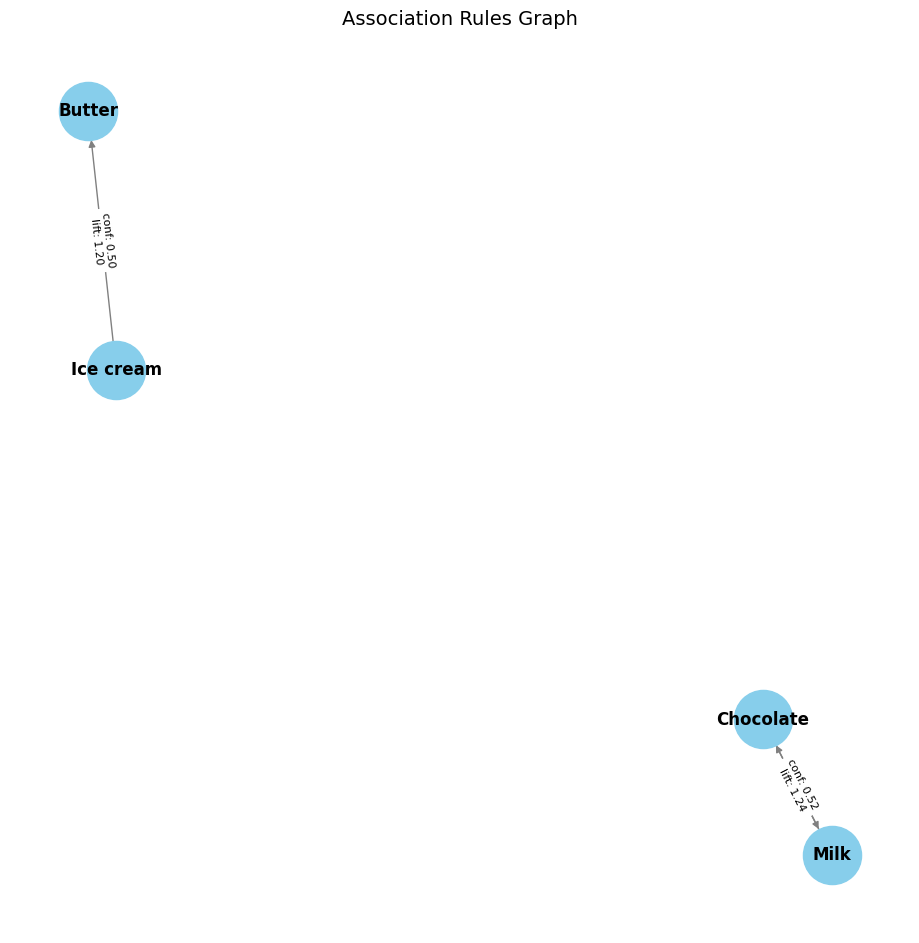

In [ ]:
# displays network graph
plt.figure(figsize=(9, 9))
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1750, font_size=12, font_weight='bold', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=rule_labels, font_size=8)

plt.title("Association Rules Graph", fontsize=14)
plt.axis('off')
plt.show()